<a href="https://colab.research.google.com/github/jameschapman19/cca_zoo/blob/main/tutorial_notebooks/cca_zoo_weights_and_sparsity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A tutorial on using cca-zoo to generate multiview models with sparsity on weights

In [1]:
!pip install cca-zoo --upgrade

     |████████████████████████████████| 68 kB 2.8 MB/s 
     |████████████████████████████████| 28.5 MB 49 kB/s 
     |████████████████████████████████| 2.1 MB 45.2 MB/s 
     |████████████████████████████████| 160 kB 53.3 MB/s 
     |████████████████████████████████| 23.1 MB 79.1 MB/s 
     |████████████████████████████████| 154 kB 47.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [20]:
from cca_zoo.models import PMD, SCCA, ElasticCCA, CCA, PLS, SCCA_ADMM, SpanCCA
from cca_zoo.model_selection import GridSearchCV
from cca_zoo.data import generate_covariance_data
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd

## Generate some data
set the true correlation and the sparsity of the true weights

In [3]:
np.random.seed(42)
n=200
p=100
q=100
view_1_sparsity=0.1
view_2_sparsity=0.1
true_latent_dims=1

(X,Y),(tx, ty)=generate_covariance_data(n,view_features=[p,q],latent_dims=true_latent_dims,
                                        view_sparsity=[view_1_sparsity,view_2_sparsity],correlation=[0.9])
#normalize weights for comparability
tx/=np.sqrt(n)
ty/=np.sqrt(n)

In [4]:
def plot_true_weights_coloured(ax, weights, true_weights, title=''):
    ind = np.arange(len(true_weights))
    mask = np.squeeze(true_weights == 0)
    ax.scatter(ind[~mask], weights[~mask], c='b')
    ax.scatter(ind[mask], weights[mask], c='r')
    ax.set_title(title)

def plot_model_weights(wx,wy,tx,ty):
    fig,axs=plt.subplots(2,2,sharex=True,sharey=True)
    plot_true_weights_coloured(axs[0,0],tx,tx,title='true x weights')
    plot_true_weights_coloured(axs[0,1],ty,ty,title='true y weights')
    plot_true_weights_coloured(axs[1,0],wx,tx,title='model x weights')
    plot_true_weights_coloured(axs[1,1],wy,ty,title='model y weights')
    plt.tight_layout()
    plt.show()

## First try with CCA

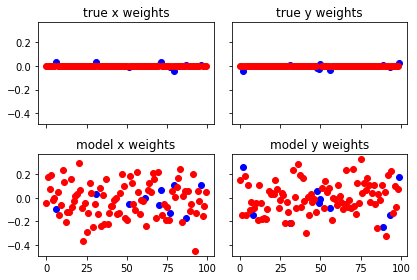

In [5]:
#fit a cca model
cca=CCA().fit([X,Y])

plot_model_weights(cca.weights[0],cca.weights[1],tx,ty)

## PLS

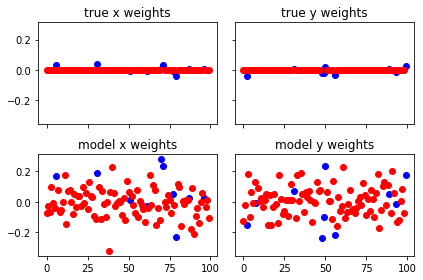

In [6]:
#fit a pls model
pls=PLS().fit([X,Y])

plot_model_weights(pls.weights[0],pls.weights[1],tx,ty)

## Penalized Matrix Decomposition (Sparse CCA by Witten)
Initially set c=2 for both views arbitrarily

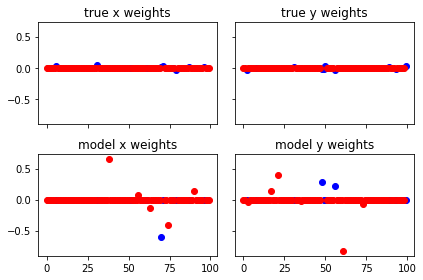

In [7]:
#fit a pmd model
pmd=PMD(c=[2,2]).fit([X,Y])

plot_model_weights(pmd.weights[0],pmd.weights[1],tx,ty)

## Tracking the objective
For these iterative algorithms, you can access the convergence over iterations

Text(0.5, 0, '#iterations')

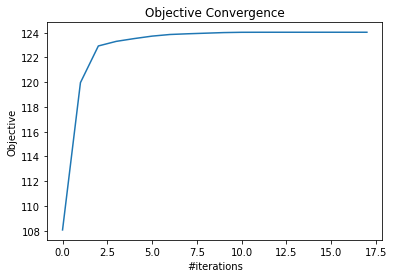

In [13]:
#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(pmd.track[0]['objective']).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

### We can also tune the hyperparameter using GridSearchCV

In [17]:
#Set up a grid. We can't use c<1 or c>sqrt(#features)
c1 = [1, 3, 7, 9]
c2 = [1, 3, 7, 9]
param_grid = {'c': [c1,c2]}

#GridSearchCV can use multiple cores (jobs) and takes folds (number of cv folds) as a parameter. It can also produce a plot.
pmd = GridSearchCV(PMD(),param_grid=param_grid,
    cv=3,
    verbose=True).fit([X,Y])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


Also the model object now has a pandas dataframe containing the results from each fold

In [21]:
pd.DataFrame(pmd.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034242,0.006790,0.001647,0.000124,"[1, 1]","{'c': [1, 1]}",0.052058,-0.033554,-0.071958,-0.017818,0.051838,13
1,0.036055,0.005429,0.001595,0.000006,"[1, 3]","{'c': [1, 3]}",0.153789,0.360482,0.036318,0.183530,0.134000,2
2,0.033163,0.001488,0.001605,0.000035,"[1, 7]","{'c': [1, 7]}",0.160803,0.331418,-0.013043,0.159726,0.140628,4
3,0.027350,0.003010,0.001567,0.000019,"[1, 9]","{'c': [1, 9]}",0.164070,0.330148,-0.001263,0.164318,0.135298,3
4,0.044610,0.015716,0.001572,0.000018,"[3, 1]","{'c': [3, 1]}",0.073034,-0.208602,-0.024809,-0.053459,0.116749,15
5,0.171106,0.070984,0.001584,0.000017,"[3, 3]","{'c': [3, 3]}",0.046186,0.600012,0.414416,0.353538,0.230160,1
6,0.243098,0.042868,0.001619,0.000019,"[3, 7]","{'c': [3, 7]}",0.014920,-0.091810,0.163879,0.028996,0.104858,10
7,0.224637,0.019915,0.001643,0.000097,"[3, 9]","{'c': [3, 9]}",-0.060565,0.275957,0.113212,0.109535,0.137409,5
8,0.040413,0.008971,0.001705,0.000155,"[7, 1]","{'c': [7, 1]}",0.024604,-0.163847,-0.104591,-0.081278,0.078681,16
9,0.189819,0.065653,0.001582,0.000013,"[7, 3]","{'c': [7, 3]}",0.049719,0.135290,-0.142186,0.014275,0.116019,11


## Sparse CCA by iterative lasso (Mai)

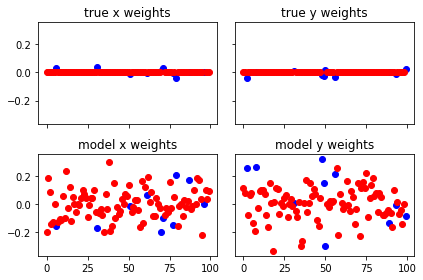

Text(0.5, 0, '#iterations')

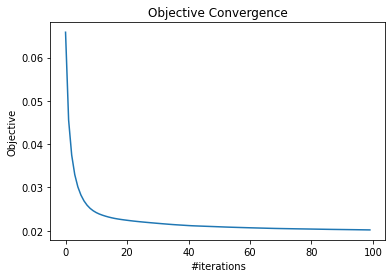

In [23]:
#fit a scca model
scca=SCCA(c=[1e-3,1e-3]).fit([X,Y])

plot_model_weights(scca.weights[0],scca.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(scca.track[0]['objective']).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

### Positivity Constraints
In this case it isn't helpful (the data were generated with positive and negative weights) but is a cool functionality!

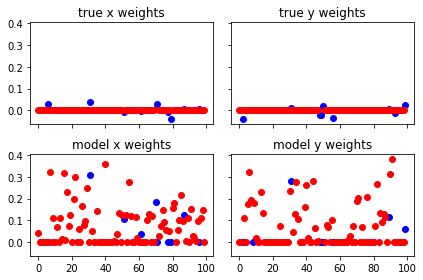

Text(0.5, 0, '#iterations')

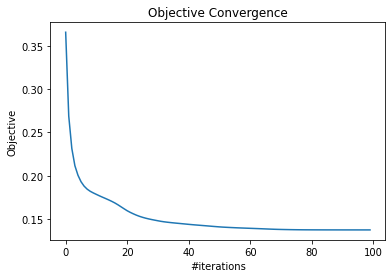

In [24]:
#fit a scca model with positivity constraints
scca_pos=SCCA(c=[1e-3,1e-3],positive=[True,True]).fit([X,Y])

plot_model_weights(scca_pos.weights[0],scca_pos.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(scca_pos.track[0]['objective']).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

## Sparse CCA by iterative elastic net (adapted from Waaijenborg)

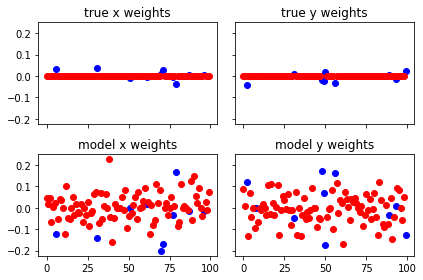

Text(0.5, 0, '#iterations')

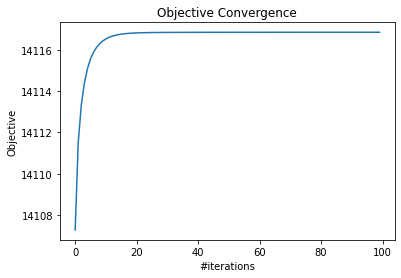

In [25]:
#fit an elastic model
#for some reason this model needs REALLY big l2 regularisation. This is actually
#the same level of l1 regularisation as SCCA
elasticcca=ElasticCCA(c=[10000,10000],l1_ratio=[0.000001,0.000001]).fit([X,Y])

plot_model_weights(elasticcca.weights[0],elasticcca.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(elasticcca.track[0]['objective']).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

## Sparse CCA by ADMM

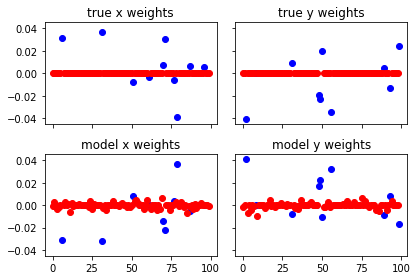

Text(0.5, 0, '#iterations')

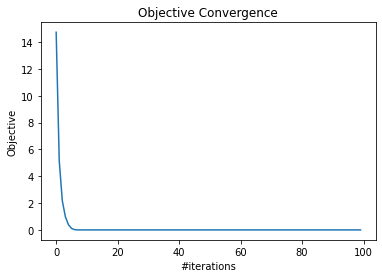

In [27]:
#fit a scca_admm model
scca_admm=SCCA_ADMM(c=[1e-3,1e-3]).fit([X,Y])

plot_model_weights(scca_admm.weights[0],scca_admm.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(scca_admm.track[0]['objective']).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

## Sparse CCA by random projection (Span CCA)
This time the regularisation parameter c is the l0 norm of the weights i.e. the maximum number of non-zero weights. Let's cheat and give it the correct numbers. We can also change the rank of the estimation as described in the paper

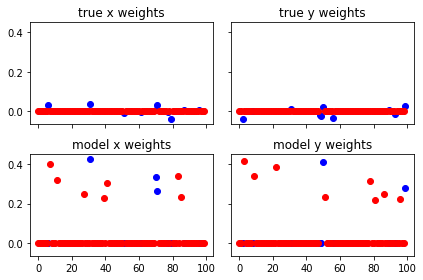

Text(0.5, 0, '#iterations')

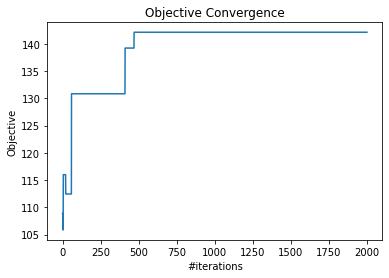

In [28]:
#fit a spancca model
spancca=SpanCCA(c=[10,10],max_iter=2000,rank=20).fit([X,Y])

plot_model_weights(spancca.weights[0],spancca.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(spancca.track[0]['objective']).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')